# **Reprise de l'exemple fourni** : Sentence Embedding

* Ce notebook présente différentes techniques de "Sentence Embeddings", permettant de générer des features à partir de phrases (ici des tweets)
* L'objectif est de pouvoir séparer les sentiments des tweets de façon automatique, via un T-SNE, qui permet une réduction des features en 2 dimensions
* C'est un notebook d'exemples afin de mieux comprendre la mise en oeuvre des techniques. Il n'est pas optimisé et doit être adapté à un nouveau contexte, en particulier sur les points suivants :
    * Le nettoyage des textes
    * les modèles BERT (`model_type`) idéalement pré-entraînés sur des données similaires au contexte (ici le modèle `'cardiffnlp/twitter-roberta-base-sentiment'` surperforme le modèle de base car il a été pré-entraîné sur des tweets)
    * La taille des vecteurs (`max_length`)
    * Le `batch_size`
    * La perplexité du Tsne (`perplexity` à 30 par défaut)

# Chargement des données

(14640, 14)


,n,n_u,n_na,Filling rate,Shannon entropy,dtypes
tweet_id,14640,14485,0,1.000000,0.989413,int64
airline_sentiment,14640,3,0,1.000000,0.000205,object
airline_sentiment_confidence,14640,1023,0,1.000000,0.069877,float64
negativereason,9178,10,5462,0.626913,0.001090,object
negativereason_confidence,10522,1410,4118,0.718716,0.134005,float64
airline,14640,6,0,1.000000,0.000410,object
airline_sentiment_gold,40,3,14600,0.002732,0.075000,object
name,14640,7701,0,1.000000,0.526025,object
negativereason_gold,32,13,14608,0.002186,0.406250,object
retweet_count,14640,18,0,1.000000,0.001230,int64


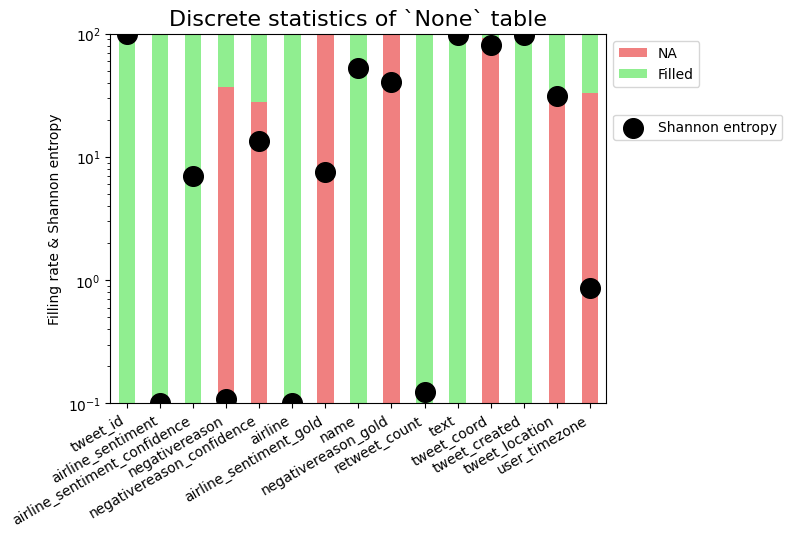

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
567845382102859777,negative,1.0,Bad Flight,0.3535,Delta,NaN,brian_cristiano,NaN,0,"@JetBlue so I'm penalized for packing lightly,...",NaN,2015-02-17 16:37:43 -0800,"New York, New York",Eastern Time (US & Canada)
569583725408870401,negative,1.0,Cancelled Flight,0.6313,US Airways,NaN,drewdenker,NaN,0,@USAirways waiting all day at ATL since flight...,NaN,2015-02-22 11:45:17 -0800,NaN,NaN
567807375667912704,negative,1.0,Late Flight,1.0000,Delta,NaN,Tubulus,NaN,0,@jetblue any idea where the plane for flight 6...,NaN,2015-02-17 14:06:42 -0800,NaN,Atlantic Time (Canada)


In [1]:
from tx_ml import load
from pepper_utils import show_discrete_stats

raw_tweets = load('Tweets.csv')
print(raw_tweets.shape)
show_discrete_stats(raw_tweets.reset_index())
display(raw_tweets.sample(3))

## Filtrage sur un niveau de confiance maximal du sentiment

In [2]:
raw_tweets.airline_sentiment_confidence.value_counts(normalize=True)

1.0000    0.713456
0.6667    0.004850
0.6632    0.002391
0.6596    0.002049
0.6559    0.002049
            ...   
0.3674    0.000068
0.6155    0.000068
0.3708    0.000068
0.6905    0.000068
0.3487    0.000068
Name: airline_sentiment_confidence, Length: 1023, dtype: float64

In [3]:
# Filtre de tweets avec un niveau de confiance à 1 sur le sentiment
import pandas as pd

raw_tweets = raw_tweets[raw_tweets.airline_sentiment_confidence == 1]
print(raw_tweets.shape)

vc = pd.concat([
    raw_tweets.airline_sentiment.value_counts().rename('#'),
    raw_tweets.airline_sentiment.value_counts(normalize=True).rename('%')
], axis=1)
display(vc)

(10445, 14)


,#,%
negative,7382,0.706750
neutral,1548,0.148205
positive,1515,0.145045


# Echantillonnage

Ehantillon de 3000 tweets, associés à un sentiment pour moitié positif, pour moitié négatif.

La sélection des 1500 premiers positifs et 1500 premiers négatifs fait superformer les ARI.

La version revisitée réalise un échantillonage aléatoire de ces 1500 + 1500 tweets.

In [5]:
from tx_ex_depr import depr_3k_sample

rt_3k_sample = depr_3k_sample(raw_tweets)

(3000, 14)

# Nettoyage du texte

In [6]:
from tx_ml import preprocess, save_as

preprocess(rt_3k_sample)
save_as(rt_3k_sample, 'depr_3k_sample_clean.csv')

# Préparation commune des traitements

## Lecture dataset

In [7]:
from tx_ml import load

tweets = load('depr_3k_sample_clean.csv')
print(tweets.shape)

(3000, 17)


In [8]:
from tx_ex_depr import depr_encode_cats
import numpy as np
cat_codes, cat_labels = depr_encode_cats(tweets.airline_sentiment)
print('categories : ', cat_labels)
display(np.unique(cat_codes, return_counts=True))

categories :  ['negative', 'positive']


(array([0, 1]), array([1500, 1500], dtype=int64))

In [9]:
from tx_ex_depr import depr_count_words
tweets['bow_len'] = tweets.sent_bow.apply(depr_count_words)
print("max sent_bow sentence length : ", tweets.bow_len.max())
tweets['deep_learn_len'] = tweets.sent_deep_learn.apply(depr_count_words)
print("max sent_deep_learn length : ", tweets.deep_learn_len.max())

max sent_bow sentence length :  22
max sent_deep_learn length :  42


# Bag of word - Tf-idf

## Préparation des phrases

In [10]:
# création du bag of words (CountVectorizer et Tf-idf)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

count_vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
tf_idf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

sent_bow_lem = tweets.sent_bow_lem
c_sent_bow_lem = count_vectorizer.fit_transform(sent_bow_lem)
f_sent_bow_lem = tf_idf_vectorizer.fit_transform(sent_bow_lem)

Sparsity index: 0.17


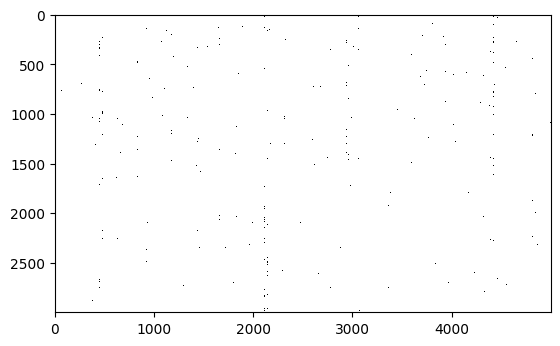

Sparsity index: 0.17


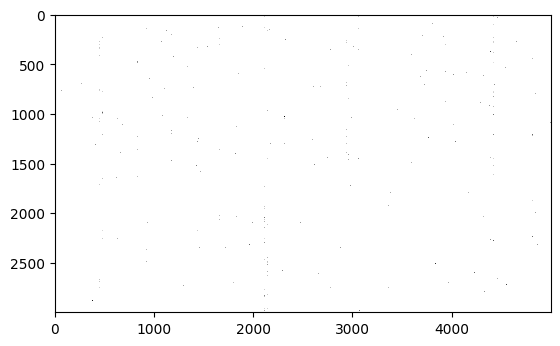

In [11]:
from tx_ml import show_sparsity

show_sparsity(c_sent_bow_lem)
show_sparsity(f_sent_bow_lem)

## Exécution des modèles

In [12]:
from tx_ml import tsne_kmeans_ari
print("CountVectorizer : ")
print("-----------------")
c_X_tsne, c_clu_labels, c_ari = tsne_kmeans_ari(c_sent_bow_lem, cat_codes, cat_labels)
print()
print("Tf-idf : ")
print("--------")
f_X_tsne, f_clu_labels, f_ari = tsne_kmeans_ari(f_sent_bow_lem, cat_codes, cat_labels)

CountVectorizer : 
-----------------
T-SNE time: 39.41s
KMeans time: 0.16s
ARI time: 0.00s
Total time : 39.57s

ARI : 0.525

Tf-idf : 
--------
T-SNE time: 34.87s
KMeans time: 0.25s
ARI time: 0.00s
Total time : 35.12s

ARI : 0.502


## Graphiques

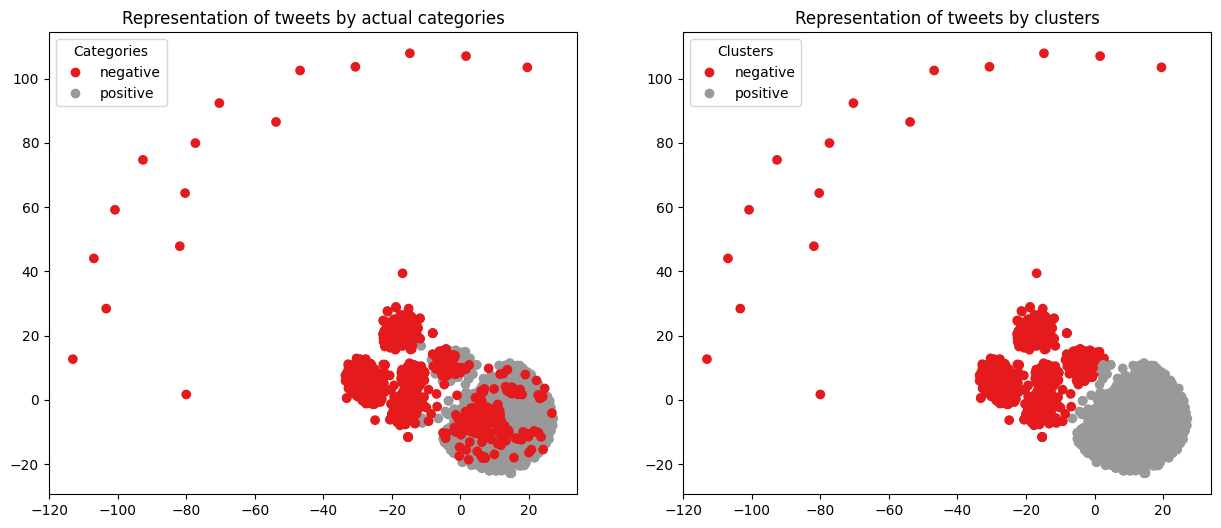

ARI :  0.5249856424186541


In [13]:
from tx_ml import show_tsne
show_tsne(cat_codes, cat_labels, c_X_tsne, c_clu_labels, c_ari)

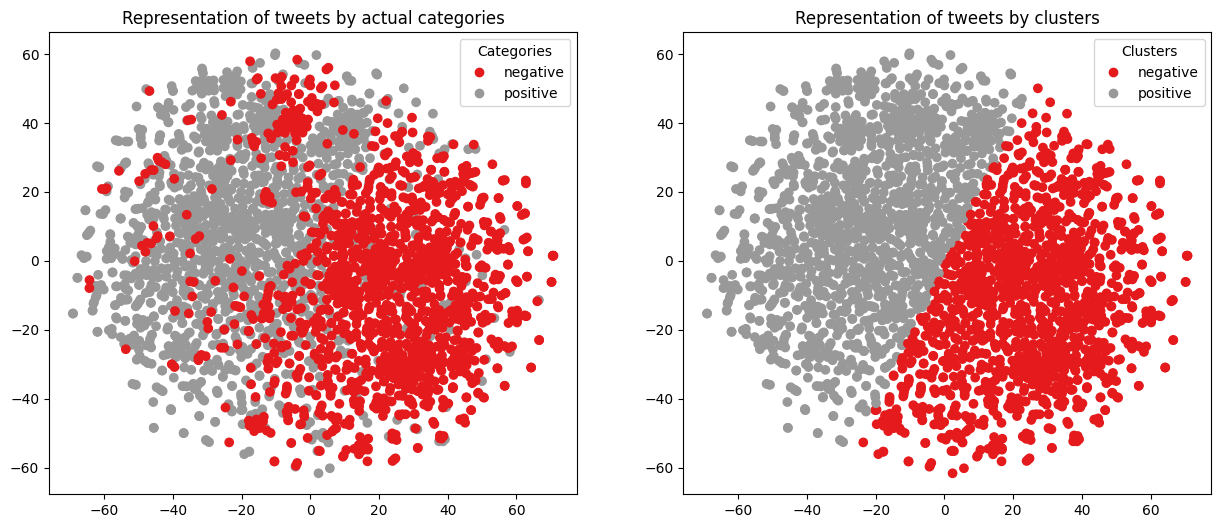

ARI :  0.502042474173476


In [14]:
from tx_ml import show_tsne
show_tsne(cat_codes, cat_labels, f_X_tsne, f_clu_labels, f_ari)

# Word2Vec

ARI : 0.3

Les deux fonctions suivantes concernent la construction d'un modèle d'embedding en utilisant le modèle Word2Vec et le tokenizer Keras. La première fonction `get_embedding_matrix` sert à créer la matrice d'embedding en utilisant le modèle Word2Vec et le tokenizer Keras. Le but est de convertir chaque mot en vecteur à partir du modèle Word2Vec, et de stocker ces vecteurs dans une matrice. La matrice aura la forme `(vocab_size, w2v_size)`, où `vocab_size` est la taille du vocabulaire du tokenizer Keras et `w2v_size` est la dimension du modèle Word2Vec.

La seconde fonction `get_embeddeding_model` sert à construire un modèle Keras qui prend en entrée des phrases tokenizées et renvoie les vecteurs d'embedding associés. Elle crée un modèle Keras avec une entrée de forme `(nombre de phrases, longueur maximale de la phrase)` et renvoie un vecteur d'embedding de longueur `w2v_size` pour chaque phrase. Les poids pré-entraînés de la matrice d'embedding sont attachés à la couche d'embedding du modèle.

## Création du modèle Word2Vec

In [15]:
from tx_ml import load
tweets = load('depr_3k_sample_clean.csv')
sent_bow_lem = tweets.sent_bow_lem
display(sent_bow_lem)

tweet_id
570301031407624196    virginamerica really aggressive blast obnoxiou...
570300817074462722                   virginamerica really big bad thing
570300767074181121    virginamerica seriously would pay flight seat ...
570276917301137409    virginamerica flew nyc sfo last week could n't...
570256553502068736    virginamerica guy messed seating reserved seat...
                                            ...                        
569631742631354369         americanair flight time late flightly though
569627200133197824    americanair yes called number skype…well worth...
569625356942098432    americanair rdu customer service awesome thank...
569623364337168384          americanair always enjoy time now plane dfw
569621883282280448    americanair aa2416 time awesome flight great j...
Name: sent_bow_lem, Length: 3000, dtype: object

Globals

In [16]:
w2v_size = 300
w2v_window = 5
w2v_min_count = 1
w2v_epochs = 100
maxlen = 24 # adapt to length of sentences

List of lists of Gesim preprocessed words

In [17]:
from tx_ml import gesim_simple_preprocess
sents = gesim_simple_preprocess(sent_bow_lem)
print(sents[:5])

[['virginamerica', 'really', 'aggressive', 'blast', 'obnoxious', 'entertainment', 'guest', 'face', 'amp', 'little', 'recourse'], ['virginamerica', 'really', 'big', 'bad', 'thing'], ['virginamerica', 'seriously', 'would', 'pay', 'flight', 'seat', 'playing', 'really', 'bad', 'thing', 'flying'], ['virginamerica', 'flew', 'nyc', 'sfo', 'last', 'week', 'could', 'fully', 'sit', 'seat', 'due', 'two', 'large', 'gentleman', 'either', 'side', 'help'], ['virginamerica', 'guy', 'messed', 'seating', 'reserved', 'seating', 'friend', 'guy', 'gave', 'seat', 'away', 'want', 'free', 'internet']]


In [18]:
from tx_ml import fit_word2vec
w2v_model = fit_word2vec(sents)

Build & train Word2Vec model ...
Vocabulary size: 4809
Word2Vec trained


In [19]:
model_vectors = w2v_model.wv
print(f"model_vectors ({len(model_vectors)}", model_vectors)
w2v_words = model_vectors.index_to_key
print(f"w2v_words ({len(w2v_words)})", w2v_words[:10])
print("flight vector", model_vectors['flight'][:50])

model_vectors (4809 KeyedVectors<vector_size=300, 4809 keys>
w2v_words (4809) ['united', 'flight', 'thanks', 'southwestair', 'jetblue', 'thank', 'service', 'customer', 'virginamerica', 'americanair']
flight vector [-0.8552871   1.0236201  -0.3959248   0.32554677  0.17287117 -0.5185497
 -1.1437409   0.79823536  0.02067649 -0.10347501 -0.08363033  0.13510911
 -0.42222726  0.28717425 -0.7277135   0.25383556 -0.44744536 -0.11010668
  0.6690094   0.5396775  -0.53488404 -0.4011301  -0.02040694  0.6571445
  0.2820481  -0.4089117  -0.04568641  0.11622966 -0.3687294  -0.10747371
  0.13061047 -0.8376953   0.00804138  0.85271853 -0.02021371  0.09880249
  0.6625637  -0.04873101 -0.20724326  0.05130643  0.12161798 -0.00346422
  0.3003549   0.37956765  0.00659092 -0.31162903  1.2615054  -0.22264059
  0.49453458 -0.2709803 ]


In [20]:
from tx_ml import fit_keras_tokenizer
keras_tokenizer, x_sents = fit_keras_tokenizer(sents)
display(keras_tokenizer)
print(x_sents.shape)
display(x_sents)

Fit Tokenizer ...
Number of unique words: 4810


(3000, 24)


array([[   9,   51, 1450, ...,    0,    0,    0],
       [   9,   51,  182, ...,    0,    0,    0],
       [   9,  246,   28, ...,    0,    0,    0],
       ...,
       [  10,  701,    8, ...,    0,    0,    0],
       [  10,  119,  711, ...,    0,    0,    0],
       [  10, 1132,   14, ...,    0,    0,    0]])

## Création de la matrice d'embedding

In [21]:
from tx_ml import get_embedding_matrix
embedding_matrix = get_embedding_matrix(w2v_model, keras_tokenizer)

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix:  (4810, 300)


## Création du modèle d'embedding

In [22]:
from tx_ml import get_embedding_model
keras_model = get_embedding_model(x_sents, w2v_model, keras_tokenizer, embedding_matrix)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           1443000   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,443,000
Trainable params: 1,443,000
Non-trainable params: 0
_________________________________________________________________


## Exécution du modèle

In [23]:
embeddings = keras_model.predict(x_sents)
embeddings.shape

94/94 [==============================] - 0s 2ms/step


(3000, 300)

In [24]:
from tx_ml import tsne_kmeans_ari
wve_X_tsne, wve_clu_labels, wve_ari = tsne_kmeans_ari(embeddings, cat_codes, cat_labels)

T-SNE time: 35.17s
KMeans time: 0.26s
ARI time: 0.00s
Total time : 35.44s

ARI : 0.5948


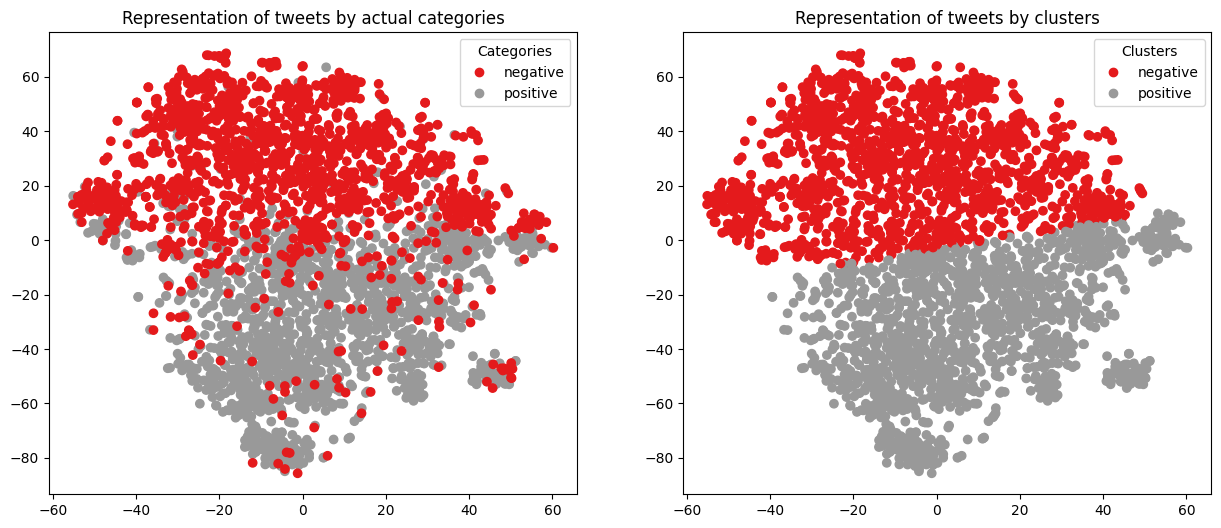

ARI :  0.5948200234374047


In [25]:
from tx_ml import show_tsne
show_tsne(cat_codes, cat_labels, wve_X_tsne, wve_clu_labels, wve_ari)

# BERT

ARI : 0.5

In [26]:
from tx_ml import load, encode_cats
tweets = load('depr_3k_sample_clean.csv')
cat_codes, cat_labels = encode_cats(tweets.airline_sentiment)
sents = tweets.sent_deep_learn

In [27]:
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
n_gpu = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available:", n_gpu)
print("Built with cuda:", tf.test.is_built_with_cuda())

Tensorflow version: 2.11.0
Num GPUs Available: 0
Built with cuda: False


## BERT HuggingFace

### 'bert-base-uncased'

In [28]:
from transformers import TFAutoModel
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [29]:
# Création des features
from tx_ml import extract_bert_sentence_embeddings
bert_features, _ = extract_bert_sentence_embeddings(
    model,
    model_type,
    sents, 
    max_length,
    batch_size,
    mode='HF'
)

300/300 [==============================] - 225s 734ms/step


In [30]:
from tx_ml import tsne_kmeans_ari
bert_X_tsne, bert_clu_labels, bert_ari = tsne_kmeans_ari(bert_features, cat_codes, cat_labels)

T-SNE time: 38.43s
KMeans time: 0.22s
ARI time: 0.00s
Total time : 38.66s

ARI : 0.6346


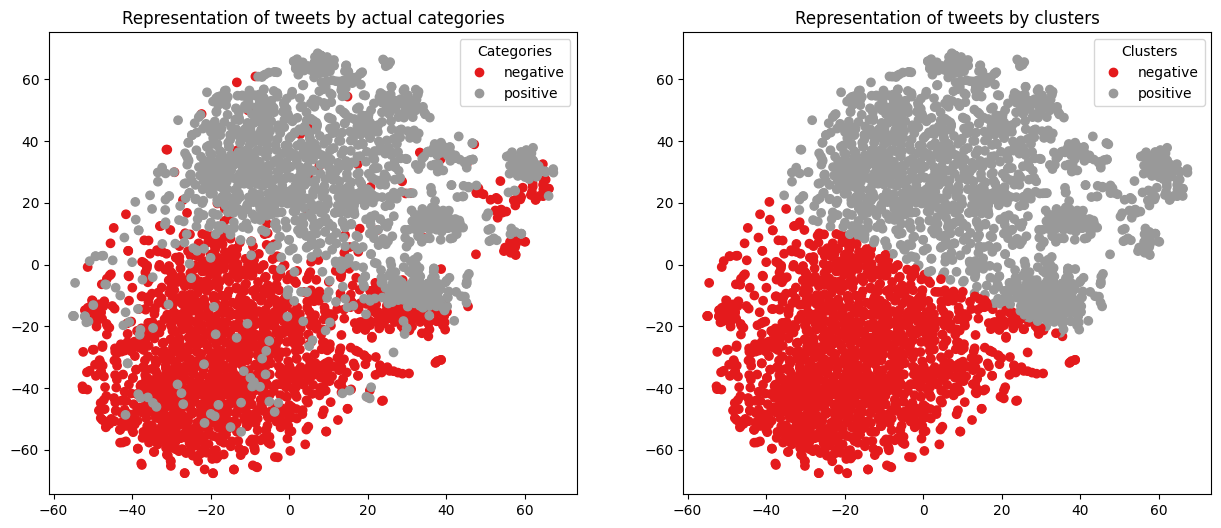

ARI :  0.6345562436759368


In [31]:
from tx_ml import show_tsne
show_tsne(cat_codes, cat_labels, bert_X_tsne, bert_clu_labels, bert_ari)

# USE - Universal Sentence Encoder

ARI : 0.6

In [32]:
from tx_ml import load, encode_cats
from pepper_utils import show_discrete_stats

tweets = load('depr_3k_sample_clean.csv')
cat_codes, cat_labels = encode_cats(tweets.airline_sentiment)
sents = tweets.sent_deep_learn

In [33]:
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
n_gpu = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available:", n_gpu)
print("Built with cuda:", tf.test.is_built_with_cuda())

Tensorflow version: 2.11.0
Num GPUs Available: 0
Built with cuda: False


In [34]:
# Création des features
from tx_ml import extract_use_sentence_embeddings
use_features = extract_use_sentence_embeddings(sents)

USE time: 2.15s


In [35]:
from tx_ml import tsne_kmeans_ari
use_X_tsne, use_clu_labels, use_ari = tsne_kmeans_ari(use_features, cat_codes, cat_labels)

T-SNE time: 54.67s
KMeans time: 0.20s
ARI time: 0.00s
Total time : 54.87s

ARI : 0.7591


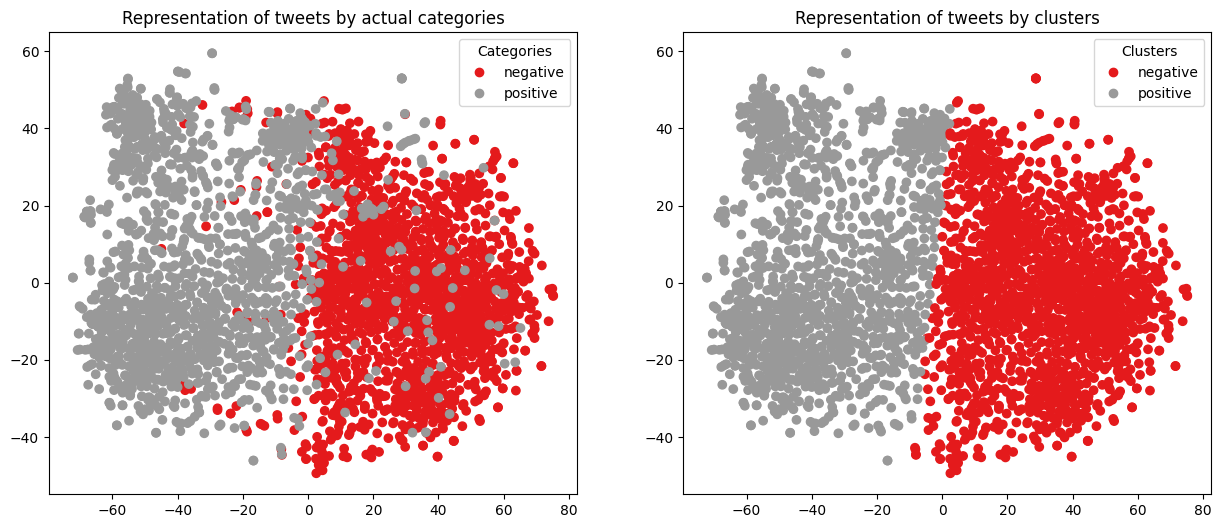

ARI :  0.7591416876727785


In [36]:
from tx_ml import show_tsne
show_tsne(cat_codes, cat_labels, use_X_tsne, use_clu_labels, use_ari)